In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import multiprocessing
from CustomFunctions import PCvisualization

def cllct_rslts(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.extend(result)
def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [5]:
#get directories and open separated datasets
from CustomFunctions.DetailedBalance import filter_dataframe

time_interval = 10 #sec/frame

datadir = 'D:/Aaron/Data/Combined_Confocal_PCA_newrotation_newalignfiltered/'
savedir = datadir + 'CK666_and_ParaNitroBlebbistatin/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

FullFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)


nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

#narrow data down to just these experiments
#add migration mode
treat = []
for f in FullFrame['cell'].to_list():
    if 'CK666' in f:
        treat.append('CK666')
    elif 'ParaNitroBleb' in f:
        treat.append('Para-Nitro-Blebbistatin')
    elif 'DMSO' in f:
        treat.append('DMSO')
    else:
        treat.append(np.nan)

# TotalFrame = FullFrame[FullFrame.cell.isin(include)]
#add the treatment categories
FullFrame['Treatment'] = pd.Categorical(treat, categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
FullFrame = FullFrame.sort_values(by='Treatment')
#limit the dataframe to only what's in the experiments of interest
TotalFrame = FullFrame.dropna(subset=['Treatment'])

#filter the dataset on speed
TotalFrame = filter_dataframe(TotalFrame, 'speed', thresh = 0.07)



In [ ]:
############### filter testing based on speed ###########


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in 

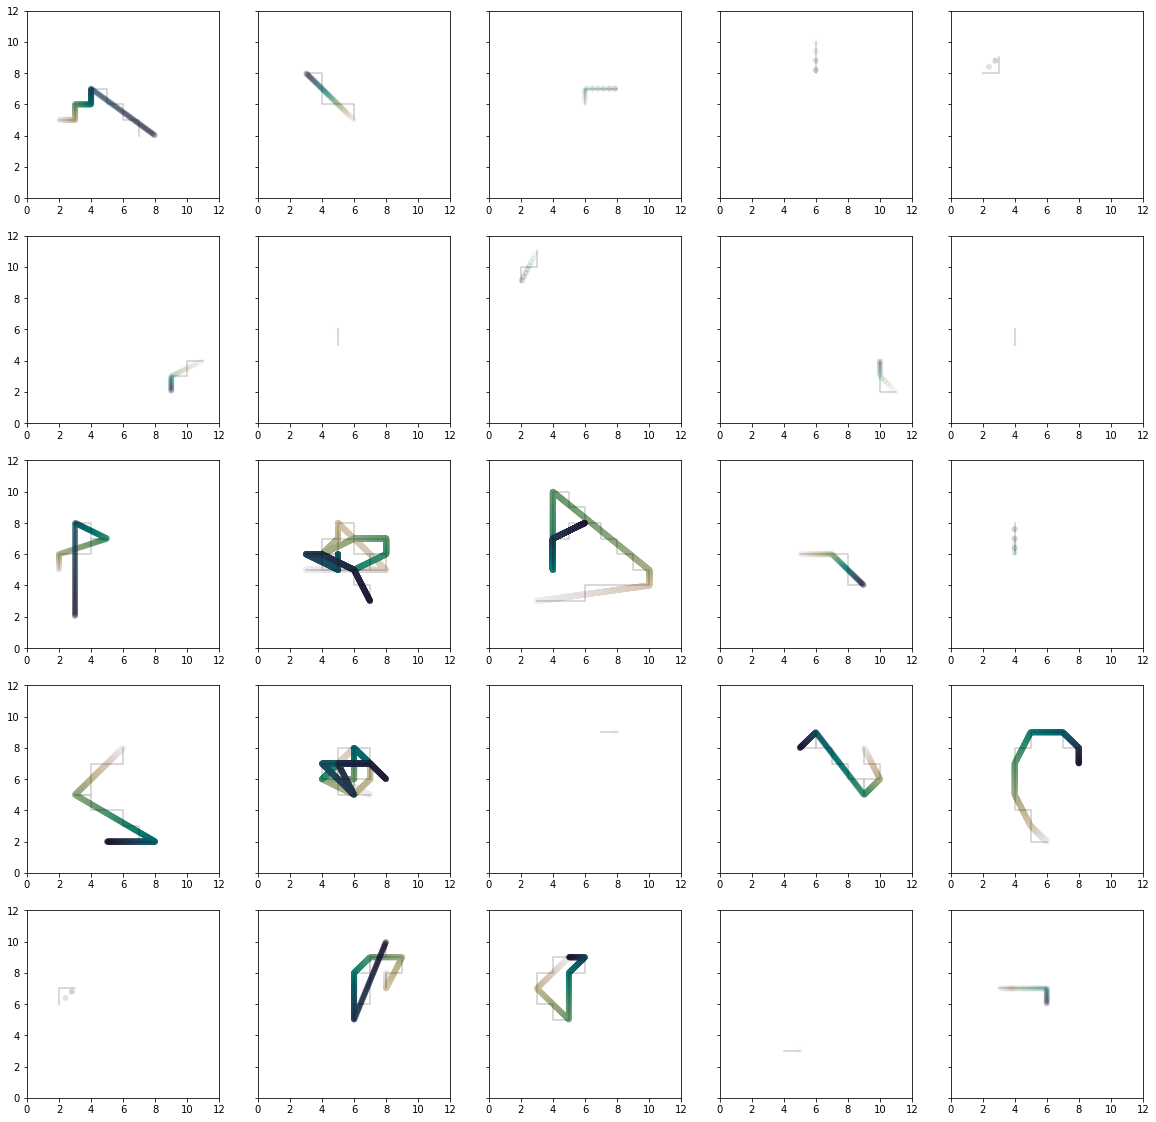

In [45]:
############# grid of plots of individual cells' INTERPOLATED transitions ###################

########### '20230509_488EGFP-CAAX_640SPY650-DNA2_cell_5' performs the exact loop #############

#the square root of plot number
pnum = 5
#randomly choose cells
sample = random.sample(list(transdf.CellID.unique()), pnum**2)

from cmocean import cm
norm = matplotlib.colors.Normalize()
cmm = cm.rain



fig, axes = plt.subplots(pnum,pnum,figsize=(20,20), sharey=True)
s = 0
#make numpy array with heatmap data
for x in range(pnum):
    for y in range(pnum):
        axes[x,y].set_xlim(0,nbins+1)
        axes[x,y].set_ylim(0,nbins+1)
        #get the next cell in the sample
        temp = transdf[transdf.CellID == sample[s]].reset_index(drop=True)
        #if temp is only 1 transition resample
        if len(temp)<2:
            temp = transdf[transdf.CellID == random.sample(list(transdf.CellID.unique()), 1)].reset_index(drop=True)
        #only get continuous frames 
        frames = temp[temp.frame.diff()>1].index.values
        if frames.size>0:
            if temp.index.values[0] != frames[0]:
                frames = np.append(temp.index.values[0], frames)
            if temp.index.values[-1] != frames[-1]:
                frames = np.append(frames, temp.index.values[-1])
            st = random.randrange(len(frames)-1)
            temp = temp.loc[frames[st]:frames[st+1]-1]
#             print(temp)
#         if s == len(sample)-1:
#             temp = alltrans.copy()
#             print(x,y)

        
        #get values of actual transitions based on the interpolated transitions
        fli = temp.frame.to_list()+[temp.frame.to_list()[-1]+1]
        acttemp = TotalFrame[(TotalFrame.CellID==temp.CellID.values[0])&(TotalFrame.frame.isin(fli))].sort_values(by='frame').reset_index(drop=True)
        #interpolate along the trajectory so I can plot dots which will represent the color gradient line
        px = acttemp.PC1bins.to_numpy()
        py = acttemp.PC2bins.to_numpy()
        pz = acttemp.frame.to_numpy()
        dist = np.nansum(scipy.spatial.distance.pdist(temp[['from_x','from_y']]))
        fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
        newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
        fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
        newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
        newz = np.arange(0,len(temp), len(temp)/len(newy))
        if len(newz)>len(newy):
            newz = newz[:-1]
        #normalize to the colors to the length of the trajectory
        norm.autoscale([0,newz.max()])
        #plot the actual transitions
        axes[x,y].scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.2, edgecolors='none')
        
        #plot the interpolated transitions
        ix = np.append(temp.from_x.to_numpy(), temp.to_x.to_numpy()[-1])
        iy = np.append(temp.from_y.to_numpy(), temp.to_y.to_numpy()[-1])
        axes[x,y].plot(ix, iy, color ='black', alpha=0.2)
        
        #add one to the sample count
        s = s+1

In [10]:
# for m, Mig in TotalFrame.groupby(['Migration_Mode','Experiment']):
#     print('_'.join(m))
transdf_sep.Treatment.unique()

['CK666', 'DMSO', 'Para-Nitro-Blebbistatin']
Categories (3, object): ['DMSO' < 'CK666' < 'Para-Nitro-Blebbistatin']

In [6]:
########### interpolate all transitions so that only individual transitions are made ###########
from CustomFunctions.DetailedBalance import interpolate_2dtrajectory
import itertools
time_interval = 10 #sec/frame


if (os.path.exists(savedir+'interpolated_PC1-PC2_transitions_separated.csv')) & (os.path.exists(savedir+'interpolated_PC1-PC2_transition_pairs_separated.csv')):
        
    transdf_sep = pd.read_csv(savedir+'interpolated_PC1-PC2_transitions_separated.csv', index_col=0)
    transpairsdf_sep = pd.read_csv(savedir+'interpolated_PC1-PC2_transition_pairs_separated.csv', index_col=0)
    print('Opened transition files')
    
    #ensure that DMSO is the first in order
    transdf_sep['Treatment'] = pd.Categorical(transdf_sep.Treatment, categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
    transdf_sep = transdf_sep.sort_values(by='Treatment')
    transpairsdf_sep['Treatment'] = pd.Categorical(transpairsdf_sep.Treatment, categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
    transpairsdf_sep = transpairsdf_sep.sort_values(by='Treatment')
else:
    if __name__ ==  '__main__':
        migresults = []
        for m, Mig in TotalFrame.groupby('Treatment'):
            results = []
            pool = multiprocessing.Pool(processes=60)
            for i, cells in Mig.groupby('CellID'):
                cells = cells.sort_values('frame').reset_index(drop = True)
                runs = list()
                #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                    currentrun = list(map(itemgetter(1), g))
                    list.append(runs, currentrun)

                for r in runs:
                    r = np.array(r, dtype=int)
                    #skip runs less than 3 frames long
                    if len(r)<2:
                        pass
                    else:
                        cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]

                        pool.apply_async(interpolate_2dtrajectory, args = (
                            time_interval,
                            cell.CellID.iloc[0],
                            cell.frame.to_list(),
                            cell[['PC1bins','PC2bins']].to_numpy(),
                            ),
                            callback = collect_results)
            pool.close()
            pool.join()


            transdf_sep = pd.DataFrame(sum([r[0] for r in results],[]))
            transdf_sep = transdf_sep.sort_values(by = ['CellID','frame']).reset_index(drop=True)
            transpairsdf_sep = pd.DataFrame(sum([r[1] for r in results],[]))
            transdf_sep['Treatment'] = pd.Categorical([m]*len(transdf_sep), categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
            transpairsdf_sep['Treatment'] = pd.Categorical([m]*len(transpairsdf_sep), categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
            migresults.append([transdf_sep,transpairsdf_sep])

    transdf_sep = pd.concat([mi[0] for mi in migresults])
    transpairsdf_sep = pd.concat([mi[1] for mi in migresults])
    transdf_sep.to_csv(savedir+'interpolated_PC1-PC2_transitions_separated.csv')
    transpairsdf_sep.to_csv(savedir+'interpolated_PC1-PC2_transition_pairs_separated.csv')
    del migresults
    print('Finished interpolating trajectories')
############## get the counts of cells leaving 

from CustomFunctions.DetailedBalance import get_transition_counts
if os.path.exists(savedir+'PC1-PC2_binned_transition_rates_separated.csv'):
    trans_rate_df_sep = pd.read_csv(savedir+'PC1-PC2_binned_transition_rates_separated.csv', index_col=0)
    print('Opened transition rate files')
    
    #ensure that DMSO is the first in order
    trans_rate_df_sep['Treatment'] = pd.Categorical(trans_rate_df_sep.Treatment, categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
    trans_rate_df_sep = trans_rate_df_sep.sort_values(by='Treatment')
else:
    trresults = []
    if __name__ ==  '__main__':
        for m, mig in transdf_sep.groupby('Treatment'):
            ttot = mig.time_elapsed.sum()
            print(ttot)
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(nbins):
                for y in range(nbins):
                    fromm = mig[(mig['from_x'] == x+1) & (mig['from_y'] == y+1)].reset_index(drop=True).to_dict()
                    to = mig[(mig['to_x'] == x+1) & (mig['to_y'] == y+1)].reset_index(drop=True).to_dict()
                    pool.apply_async(get_transition_counts, args = (
                        x+1,
                        y+1,
                        fromm,
                        to,
                        ttot,
                        ),
                        callback = collect_results)
            pool.close()
            pool.join()

            trans_rate_df_sep = pd.DataFrame(results)
            trans_rate_df_sep['Treatment'] = pd.Categorical([m]*len(trans_rate_df_sep), categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
            trans_rate_df_sep = trans_rate_df_sep.sort_values(by = ['x','y']).reset_index(drop=True)
            trresults.append(trans_rate_df_sep)

    trans_rate_df_sep = pd.concat(trresults)
    trans_rate_df_sep.to_csv(savedir+'PC1-PC2_binned_transition_rates_separated.csv')
    del trresults

    print('Finished finding transition rates')


############## BOOTSTRAP MANY TRAJECTORIES ##########
from CustomFunctions.DetailedBalance import bootstrap_trajectories

modes = transpairsdf_sep.Treatment.unique()
#if a bootstrapped data file already exists, load it, otherwise make one
if (os.path.exists(savedir+f'{modes[0]}_bootstrapped_transitions.csv')) & (os.path.exists(savedir+f'{modes[1]}_bootstrapped_transitions.csv')):
    avg_cur_mode1 = pd.read_csv(savedir+f'{modes[0]}_bootstrapped_transitions.csv', index_col=0)
    avgavg_cur_mode1 = avg_cur_mode1.groupby(['x','y','Treatment']).apply(np.mean)
    avgavg_cur_mode1 = avgavg_cur_mode1.drop(columns = ['x','y']).reset_index()
    avg_cur_mode2 = pd.read_csv(savedir+f'{modes[1]}_bootstrapped_transitions.csv', index_col=0)
    avgavg_cur_mode2 = avg_cur_mode2.groupby(['x','y','Treatment']).apply(np.mean)
    avgavg_cur_mode2 = avgavg_cur_mode2.drop(columns = ['x','y']).reset_index()
    avg_cur_mode3 = pd.read_csv(savedir+f'{modes[2]}_bootstrapped_transitions.csv', index_col=0)
    avgavg_cur_mode3 = avg_cur_mode3.groupby(['x','y','Treatment']).apply(np.mean)
    avgavg_cur_mode3 = avgavg_cur_mode3.drop(columns = ['x','y']).reset_index()
    bsframe_sep = pd.concat([avgavg_cur_mode1,avgavg_cur_mode2,avgavg_cur_mode3])
    bsframe_sep_full = pd.concat([avg_cur_mode1,avg_cur_mode2,avg_cur_mode3])
    del avg_cur_mode1
    del avg_cur_mode2
    del avg_cur_mode3
    del avgavg_cur_mode1
    del avgavg_cur_mode2
    del avgavg_cur_mode3

    
    #ensure that DMSO is the first in order
    bsframe_sep['Treatment'] = pd.Categorical(bsframe_sep.Treatment, categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
    bsframe_sep = bsframe_sep.sort_values(by='Treatment')
    bsframe_sep_full['Treatment'] = pd.Categorical(bsframe_sep_full.Treatment, categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
    bsframe_sep_full = bsframe_sep_full.sort_values(by='Treatment')
    print('Opened bootstrap file')
else:
    
    #set the total bootstrap time to the full time of a single video
    ttot = time_interval*TotalFrame.frame.max()
    
    bsresults = []
    #number of times to bootstrap
    bsiter = 5000

    for m, mig in transpairsdf_sep.groupby('Treatment'):
        start = 0
        stop = 300
        allresults = []
        while start<bsiter:
            print(f'Finished {start}, starting {start}-{stop}')
            if __name__ ==  '__main__':
                pool = multiprocessing.Pool(processes=60)
                results = []
                for x in range(start,stop+1):
                    pool.apply_async(bootstrap_trajectories, args = (
                        mig,
                        ttot,
                        nbins,
                        ),
                        callback = collect_results)
                pool.close()
                pool.join()

                allresults.extend(results)

            start = stop + 1
            stop = stop + 300
            if stop>bsiter:
                stop = bsiter

        migboot = pd.concat(allresults)
        migboot['Treatment'] = pd.Categorical([m]*len(migboot), categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
        iters = [[x]*(nbins**2) for x in range(int(len(migboot)/(nbins**2)))]#, len(migboot)
        migboot['bs_iteration'] = list(itertools.chain.from_iterable(iters))
        migboot.to_csv(savedir+f'{m}_bootstrapped_transitions.csv')
        bsresults.append(migboot)
        

        
    bsframe_sep = pd.concat(bsresults)
    del results
    del allresults
    print('Finished bootstrapping')

    
    
#### get current field for this bootstrap realization ######
####### this is for looking at data spread for the current field ############
bsfield = []
for m, mig in bsframe_sep.groupby('Treatment'):
    for x in range(nbins):
        for y in range(nbins):
            current = mig[(mig['x'] == x+1) & (mig['y'] == y+1)]
            cov = np.array([[(current.x_plus_rate.mean()-current.x_minus_rate.mean()/2),0],
                    [0, (current.y_plus_rate.mean()-current.y_minus_rate.mean())/2]])
            evals, evecs = np.linalg.eigh(cov)
            bsfield.append({'x':x+1,
                            'y':y+1,
                            'eval1':evals[1],
                            'eval2':evals[0],
                           'evec1x':evecs[0,1],
                           'evec1y':evecs[1,1],
                           'evec2x':evecs[0,0],
                           'evec2y':evecs[1,0],
                          'Treatment':m})
        
bsfield_sep = pd.DataFrame(bsfield)

Finished interpolating trajectories
100530.56715262502
45679.48194862979
29905.84244848771
Finished finding transition rates
Finished 0, starting 0-300
Finished 301, starting 301-600
Finished 601, starting 601-900
Finished 901, starting 901-1200
Finished 1201, starting 1201-1500
Finished 1501, starting 1501-1800
Finished 1801, starting 1801-2100
Finished 2101, starting 2101-2400
Finished 2401, starting 2401-2700
Finished 2701, starting 2701-3000
Finished 3001, starting 3001-3300
Finished 3301, starting 3301-3600
Finished 3601, starting 3601-3900
Finished 3901, starting 3901-4200
Finished 4201, starting 4201-4500
Finished 4501, starting 4501-4800
Finished 4801, starting 4801-5000
Finished 0, starting 0-300
Finished 301, starting 301-600
Finished 601, starting 601-900
Finished 901, starting 901-1200
Finished 1201, starting 1201-1500
Finished 1501, starting 1501-1800
Finished 1801, starting 1801-2100
Finished 2101, starting 2101-2400
Finished 2401, starting 2401-2700
Finished 2701, starti

In [4]:
len(transdf_sep[transdf_sep.Treatment=='CK666']), len(transdf_sep[transdf_sep.Treatment=='DMSO']), len(transdf_sep[transdf_sep.Treatment=='Para-Nitro-Blebbistatin'])
# len(TotalFrame[TotalFrame.Treatment=='CK666']), len(TotalFrame[TotalFrame.Treatment=='DMSO']), len(TotalFrame[TotalFrame.Treatment=='Para-Nitro-Blebbistatin'])
# transdf_sep.sort_values(['CellID','frame']).iloc[:40]

(11994, 32405, 11311)

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator


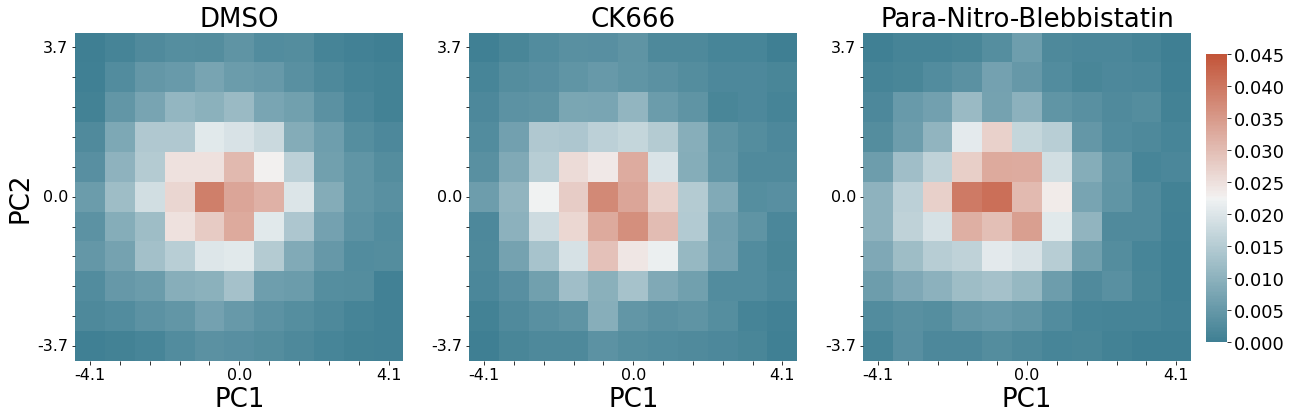

In [8]:
########### PLOT THE % TOTAL TIME SPENT IN CGPS OF THE SEPARATED MIGRATION MODES #############

fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique()),figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.91, .3, .015, .4])

for i, ax in enumerate(axes):
    mm = transdf_sep.Treatment.unique()[i]
    mdf = transdf_sep[transdf_sep.Treatment==mm]
    ttot = mdf.time_elapsed.sum()
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.sum()/ttot

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=0, vmax=0.045, #center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round(x,1) for x in centers.PC1.to_list()],
        fontsize = 16
    )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC2.to_list()],
        rotation=0,
        fontsize = 16
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 26)
    
plt.savefig(savedir + 'PC1_PC2 probability density heatmap separated.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


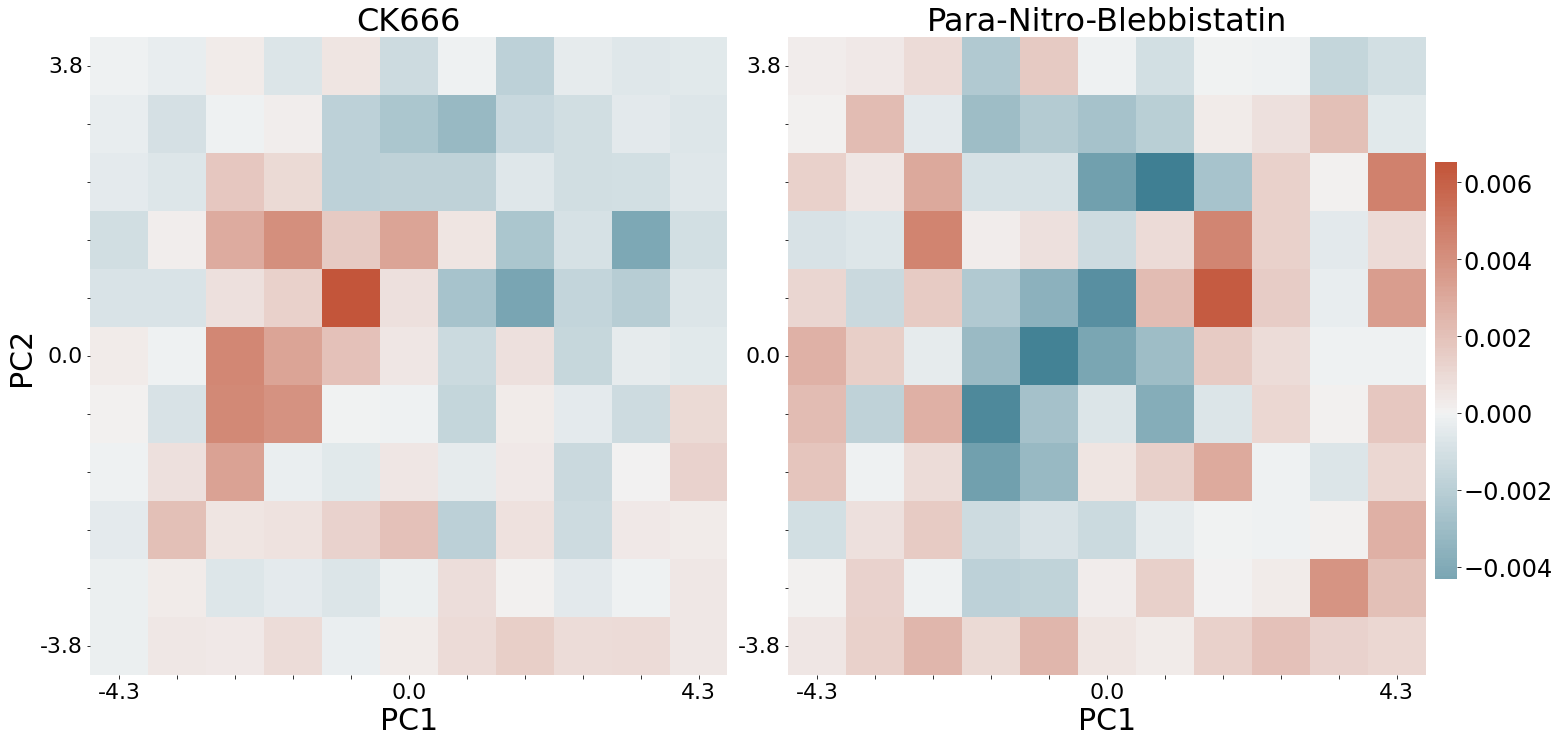

In [22]:
########### plot the DWELL TIME DIFFERENCE of the treatments in the CGPS #############

fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique())-1,figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.999, .21, .015, .58])

#calculate control heatmap to subtract from the treatments
mm = transdf_sep.Treatment.unique()[0]
mdf = transdf_sep[transdf_sep.Treatment==mm]
ttot = mdf.time_elapsed.sum()
################ heatmap of probability density #############
#make numpy array with heatmap data
ctrlhm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
        if current.empty:
            ctrlhm[y,x] = 0
        else:
            ctrlhm[y,x] = current.time_elapsed.sum()/ttot
ctrlhmnorm = ctrlhm/ctrlhm.sum()

for i, ax in enumerate(axes):
    mm = transdf_sep.Treatment.unique()[i+1]
    mdf = transdf_sep[transdf_sep.Treatment==mm]
    ttot = mdf.time_elapsed.sum()
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.sum()/ttot

    bighmnorm = bighm/bighm.sum()
    normnorm = bighmnorm-ctrlhmnorm
    
    #plot heatmap with seaborn
    sns.heatmap(
        normnorm,
#         vmin=2.5, vmax=9, 
        center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round(x,1) for x in centers.PC1.to_list()],
        fontsize = 22
    )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC2.to_list()],
        rotation=0,
        fontsize = 22
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 30)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=24)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 30)
plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 probability density DIFFERENCE heatmap separated.png', bbox_inches='tight', dpi = 500)

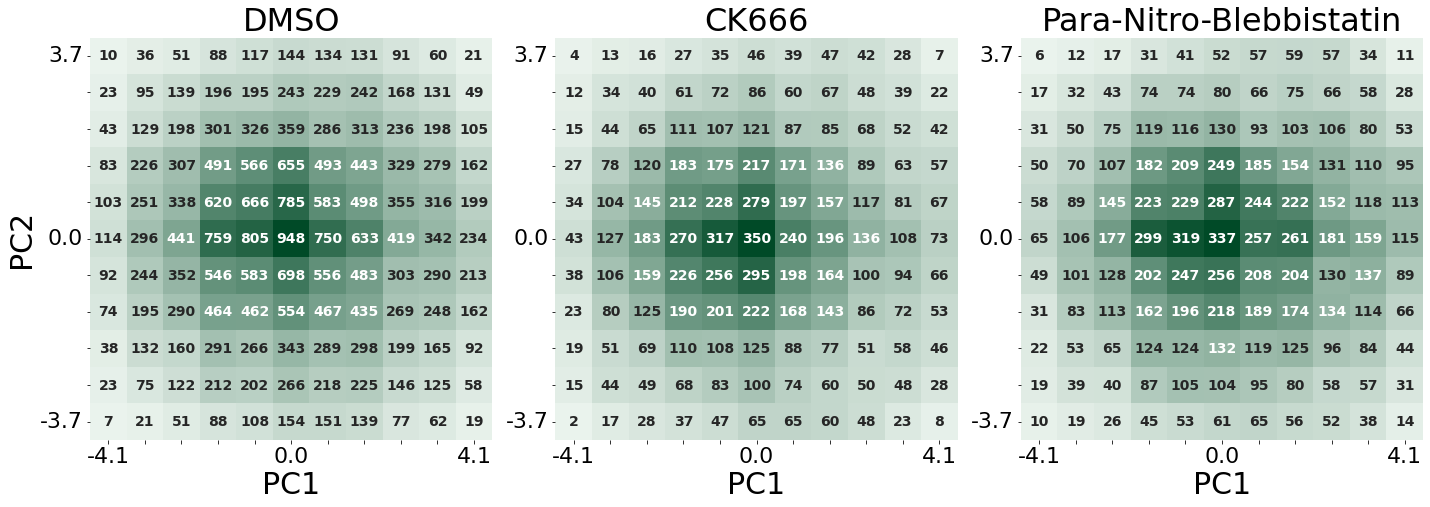

In [13]:
########### PLOT THE COUNTS OF THE BINS OF THE SEPARATED MIGRATION MODES #############

fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique()),figsize=(20,10))
#single colorbar axis
# cbar_ax = fig.add_axes([.91, .3, .015, .4])

for i, ax in enumerate(axes):
    mm = transdf_sep.Treatment.unique()[i]
    mdf = transdf_sep[transdf_sep.Treatment==mm]
    ttot = mdf.time_elapsed.sum()
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = len(current)

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=np.min(bighm[np.nonzero(bighm)]),
        vmax=bighm.max(), #center=0,
        cmap=sns.light_palette('#004a27', as_cmap=True),
        square=True,
        xticklabels = True,
        yticklabels = True,
        annot = True,
        annot_kws={"size":14,
                  'fontweight':'bold'},
        fmt = '.0f',
        ax = ax,
        cbar=False,
#         cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round(x,1) for x in centers.PC1.to_list()],
        fontsize = 22
    )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC2.to_list()],
        rotation=0,
        fontsize = 22
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 30)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 30)
plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 transition counts heatmap separated.png', bbox_inches='tight', dpi = 500)

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


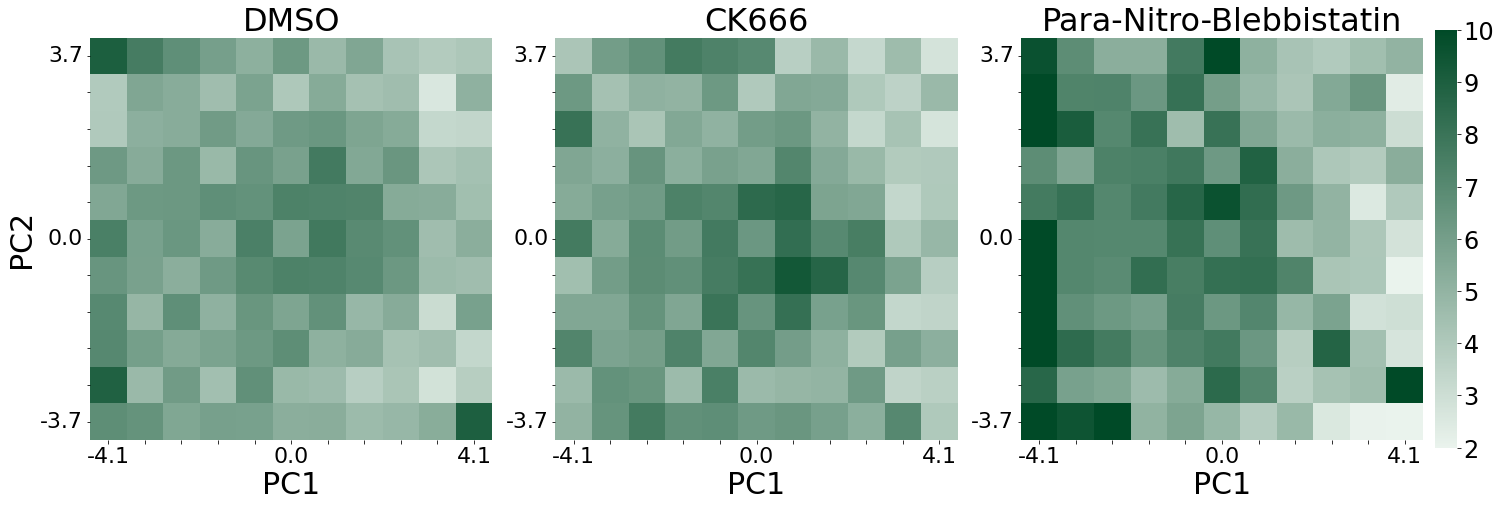

In [9]:
########### PLOT THE DWELL TIME OF THE MIGRATION MODES IN THE CGPS #############

fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique()),figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.999, .21, .015, .58])

for i, ax in enumerate(axes):
    mm = transdf_sep.Treatment.unique()[i]
    mdf = transdf_sep[transdf_sep.Treatment==mm]
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.mean()

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=2, vmax=10, #center=0,
        cmap=sns.light_palette('#004a27', as_cmap=True),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round(x,1) for x in centers.PC1.to_list()],
        fontsize = 22
    )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC2.to_list()],
        rotation=0,
        fontsize = 22
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 30)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=24)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 30)
plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 probability dwell time heatmap separated.png', bbox_inches='tight', dpi = 500)

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


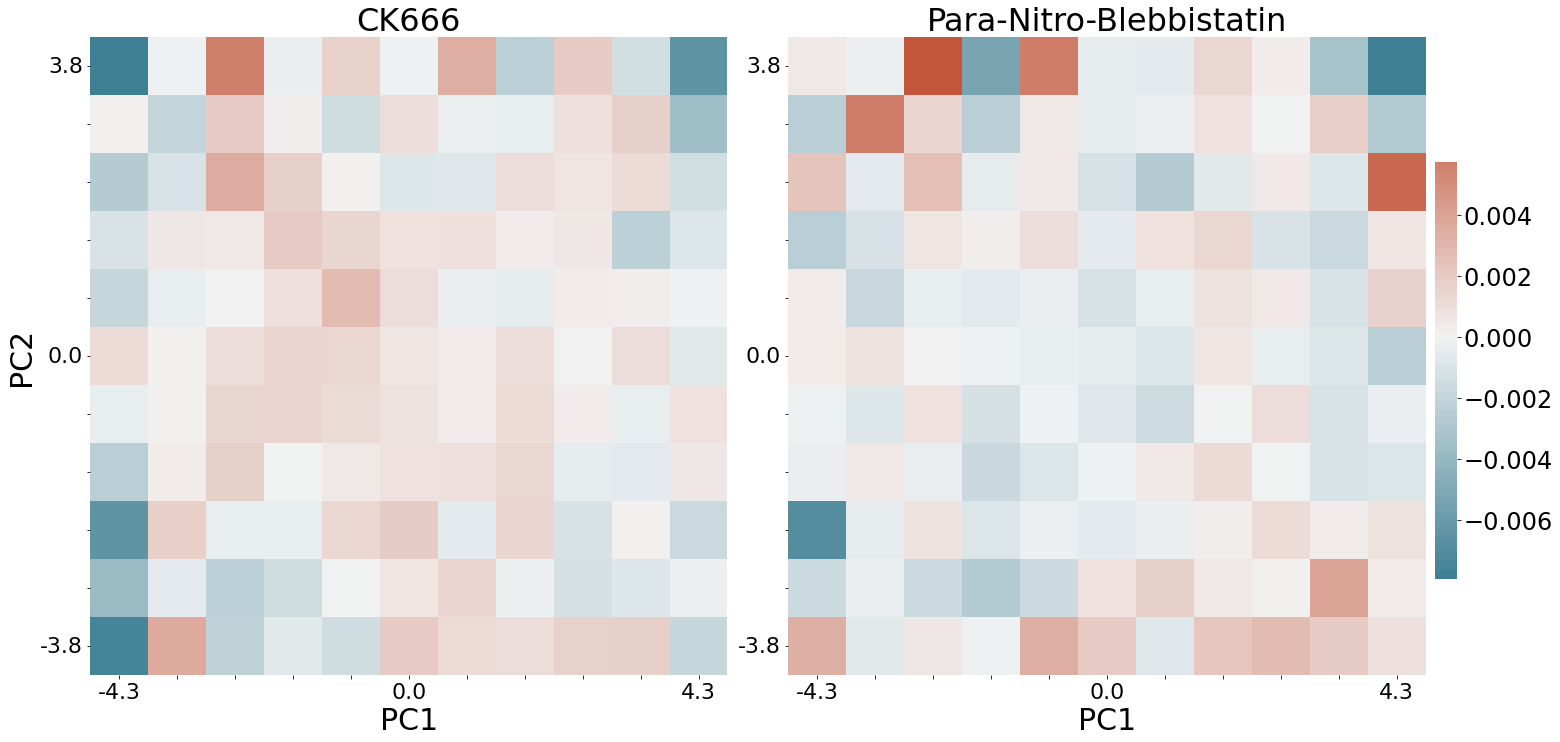

In [20]:
########### plot the DWELL TIME DIFFERENCE of the treatments in the CGPS #############

fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique())-1,figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.999, .21, .015, .58])

#calculate control heatmap to subtract from the treatments
mm = transdf_sep.Treatment.unique()[0]
mdf = transdf_sep[transdf_sep.Treatment==mm]
################ heatmap of probability density #############
#make numpy array with heatmap data
ctrlhm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
        if current.empty:
            ctrlhm[y,x] = 0
        else:
            ctrlhm[y,x] = current.time_elapsed.mean()
ctrlhmnorm = ctrlhm/ctrlhm.sum()

for i, ax in enumerate(axes):
    mm = transdf_sep.Treatment.unique()[i+1]
    mdf = transdf_sep[transdf_sep.Treatment==mm]
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.mean()

    bighmnorm = bighm/bighm.sum()
    normnorm = bighmnorm-ctrlhmnorm
    
    #plot heatmap with seaborn
    sns.heatmap(
        normnorm,
#         vmin=2.5, vmax=9, 
        center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round(x,1) for x in centers.PC1.to_list()],
        fontsize = 22
    )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC2.to_list()],
        rotation=0,
        fontsize = 22
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 30)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=24)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 30)
plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 probability dwell time DIFFERENCE heatmap separated.png', bbox_inches='tight', dpi = 500)

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(137.75, 0.5, 'PC2')

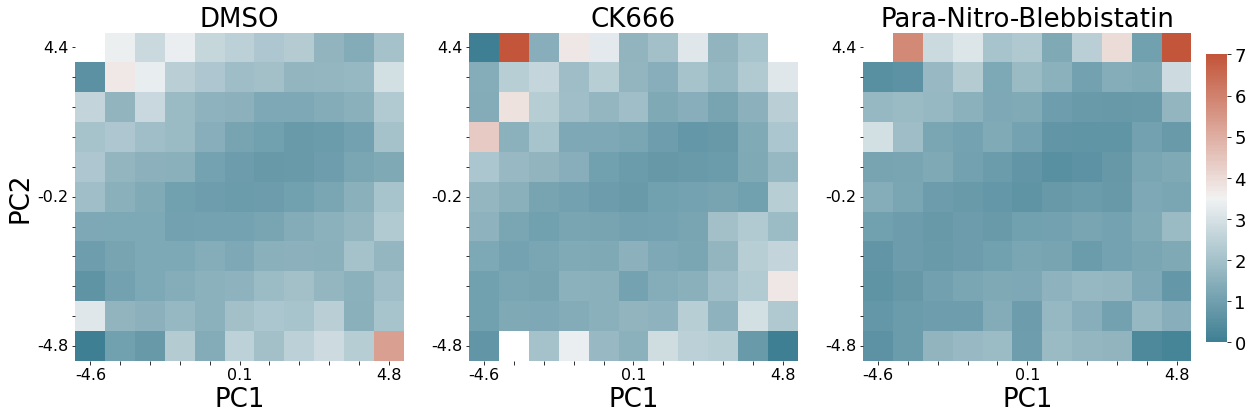

In [26]:

########### PLOT THE CGPS DISTANCE TRAVELED OF THE MIGRATION MODES #############

fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique()),figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.91, .3, .015, .4])

for i, ax in enumerate(axes):
    mm = TotalFrame.Treatment.unique()[i]
    mdf = TotalFrame[TotalFrame.Treatment==mm]
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC2bins'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.PC1_PC2_distance_to.mean()

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=0, vmax=7, #center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
        fontsize = 16
    )
    ax.set_yticklabels(
        [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
        rotation=0,
        fontsize = 16
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 26)
    
# plt.savefig(savedir + 'PC1_PC2 probability dwell time heatmap separated.png', bbox_inches='tight')

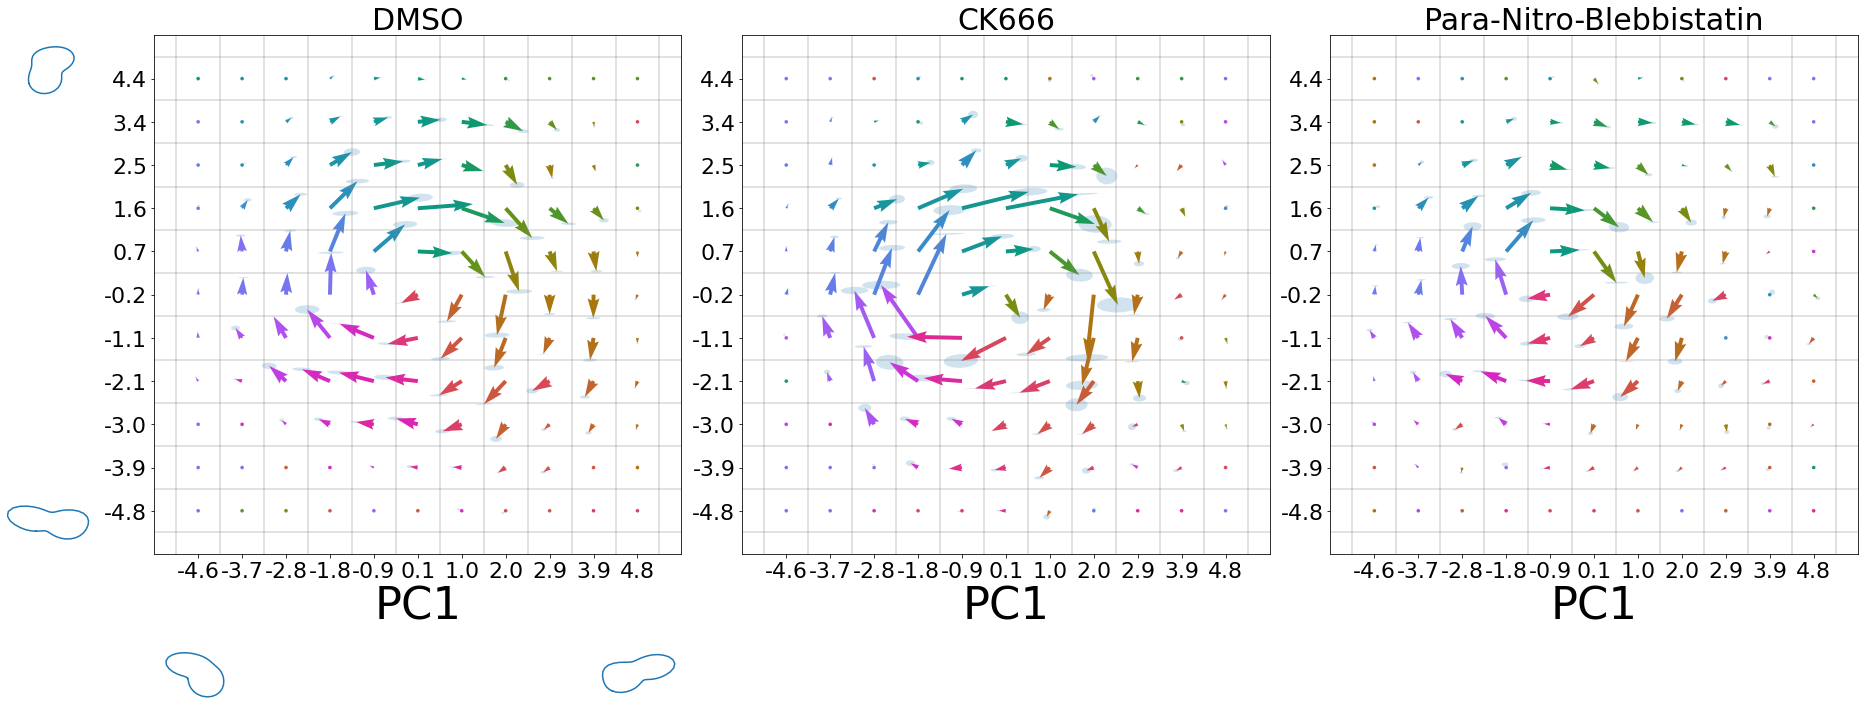

In [5]:
############## plot vectors of PC1/2 transitions from different migration modes #################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from CustomFunctions.DetailedBalance import contour_coords

# inverse scale for arrows
scale = 0.0005


# combine error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df_sep,left_on = ['x','y','Treatment'], right_on = ['x','y','Treatment'])


#do color scales stuff
norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})


meshdir = datadir + 'PC_Meshes/'

proj=[0,1]
PCkey = [1,2]
binkey = [1,5]      

fig = plt.figure(figsize=(10+(8*(len(elldf.Treatment.unique())-1)),10))

graphaxes, axes = PCvisualization.get_contours_for_axes(meshdir,
                proj,
                PCkey,
                binkey,
                graphnum = len(elldf.Treatment.unique()))


for i, ax in enumerate(graphaxes):
    mm = elldf.Treatment.unique()[i]
    mdf = elldf[elldf.Treatment==mm]
    #add "grid lines" first 
    for h in np.linspace(0.5, nbins+0.5, nbins+1):
        ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
        ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

#     #add contou line if desired
#     uple = [3,8]
#     lori = [9,3]
#     contourcoords = contour_coords(uple,lori)
#     #actually plot the contour
#     ax.plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3)

        
    for x in range(1,nbins+1):
        for y in range(1,nbins+1):
            current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
            xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
            ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

            ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                    width=np.sqrt(abs(current.eval1))*(1/scale)*2,
                      height=np.sqrt(abs(current.eval2))*(1/scale)*2,
                    angle=np.arctan2(current.evec1y,current.evec1x))
            ax.add_artist(ell)
            ell.set_alpha(0.2)

    for x in range(1,nbins+1):
        for y in range(1,nbins+1):
            current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
            xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
            ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
            anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
            ax.quiver(x,
                       y, 
                       xcurrent,
                       ycurrent,
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = scale,
#                       width = 0.012,
#                       minlength = 0.8,
                      color = cmm(norm(anglecolor)))


    #         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
    ax.set_xlabel('PC1', fontsize = 45)

    ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 22)
    ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 22)
    ax.set_xlim(0,nbins+1)
    ax.set_ylim(0,nbins+1)
    ax.set_title(mm, fontsize = 30)
    
    
axes[0].set_ylabel('PC2', fontsize = 45)
plt.tight_layout()

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)


plt.savefig(savedir + 'PC1_PC2 Vector map absolute angle colored separated.png', bbox_inches='tight')


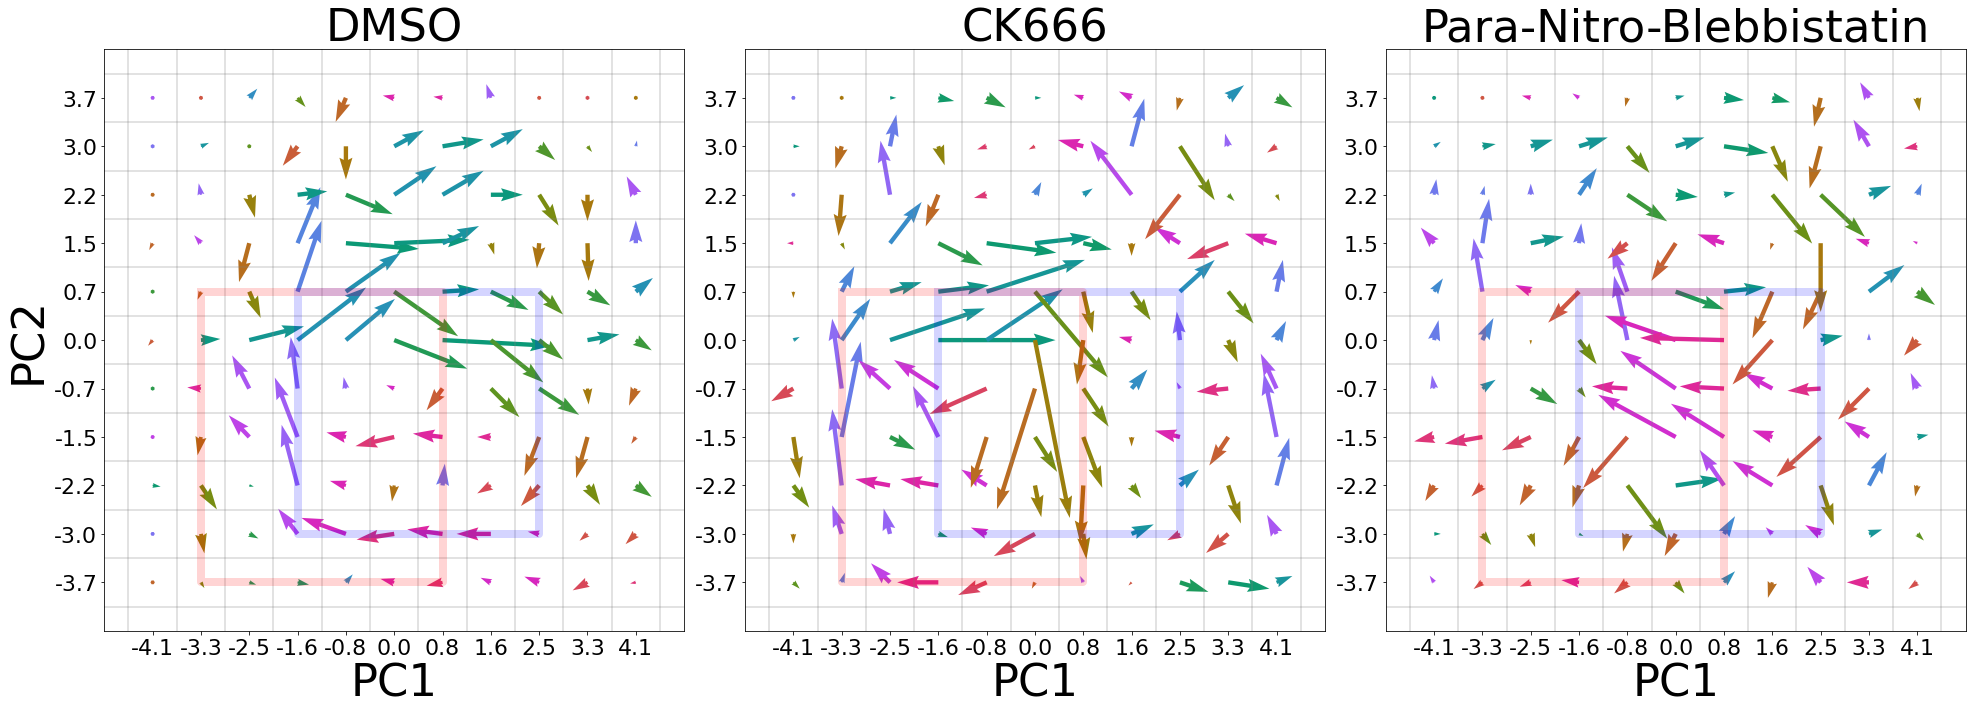

In [6]:
############## plot vectors of PC1/2 transitions from different migration modes #################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from CustomFunctions.DetailedBalance import contour_coords

# inverse scale for arrows
scale = 0.0001


# combine error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df_sep,left_on = ['x','y','Treatment'], right_on = ['x','y','Treatment'])


#do color scales stuff
norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})


meshdir = datadir + 'PC_Meshes/'

proj=[0,1]
PCkey = [1,2]
binkey = [1,5]      

fig, graphaxes = plt.subplots(1, 3, figsize=(7.5+(10*(len(elldf.Treatment.unique())-1)),10))


for i, ax in enumerate(graphaxes):
    mm = elldf.Treatment.unique()[i]
    mdf = elldf[elldf.Treatment==mm]
    #add "grid lines" first 
    for h in np.linspace(0.5, nbins+0.5, nbins+1):
        ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
        ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

        
    #add contou line if desired
    uple = [4,7]
    lori = [9,2]
    contourcoords = contour_coords(uple,lori)
    #actually plot the contour
    ax.plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='blue',alpha=0.17)
        
        
    #add contou line if desired
    uple = [2,7]
    lori = [7,1]
    contourcoords = contour_coords(uple,lori)
    #actually plot the contour
    ax.plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='red',alpha=0.17)
    


    
        
#     for x in range(1,nbins+1):
#         for y in range(1,nbins+1):
#             current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
#             xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
#             ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

#             ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
#                     width=np.sqrt(abs(current.eval1))*(1/scale)*2,
#                       height=np.sqrt(abs(current.eval2))*(1/scale)*2,
#                     angle=np.arctan2(current.evec1y,current.evec1x))
#             ax.add_artist(ell)
#             ell.set_alpha(0.2)

    for x in range(1,nbins+1):
        for y in range(1,nbins+1):
            current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
            xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
            ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
            anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
            ax.quiver(x,
                       y, 
                       xcurrent,
                       ycurrent,
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = scale,
#                       width = 0.012,
#                       minlength = 0.8,
                      color = cmm(norm(anglecolor)))


    #         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
    ax.set_xlabel('PC1', fontsize = 45)

    ax.set_xticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC1.to_list()], fontsize = 22)
    ax.set_yticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC2.to_list()], fontsize = 22)
    ax.set_xlim(0,nbins+1)
    ax.set_ylim(0,nbins+1)
    ax.set_title(mm, fontsize = 45)
    
    
graphaxes[0].set_ylabel('PC2', fontsize = 45)
plt.tight_layout()

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)


plt.savefig(savedir + 'PC1_PC2 Vector map with boxes.png', bbox_inches='tight', dpi=500)


In [22]:
######### do contour integrals for all migration modes ################
import itertools
from CustomFunctions.DetailedBalance import contour_integral
#upper left position of contour box
uple = [4,7]
#lower right position of contour box
lori = [9,2]


if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated.csv'):
    omegaframesep = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated.csv', index_col=0)
    individualoms = pd.read_csv(savedir+f'Individual_Contour_integrals_uple{uple}_lori{lori}_separated.csv', index_col=0)
    
    omegaframesep['Treatment'] = pd.Categorical(omegaframesep.Treatment, categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
    omegaframesep = omegaframesep.sort_values(by='Treatment')
    individualoms['Treatment'] = pd.Categorical(individualoms.Treatment, categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
    individualoms = individualoms.sort_values(by='Treatment')
else:
    omega_results = []
    dot_results = []
    for i, m in bsframe_sep_full.groupby('Treatment'):
        omegas = []
        dots = []
        for l, b in m.groupby('bs_iteration'):
            om, ol = contour_integral(b, uple, lori, False)
            omegas.append(om)
            dots.append(pd.DataFrame(ol))
        omega_results.append([i,omegas])
        tempdots = pd.concat(dots)
        tempdots['Treatment'] = pd.Categorical([i] * len(tempdots), categories=['DMSO','CK666','Para-Nitro-Blebbistatin'], ordered=True)
        dot_results.append(tempdots)
    omegaframesep = pd.DataFrame([o[1] for o in omega_results], index = [o[0] for o in omega_results])
    dlist = []
    for m in omegaframesep.T.columns.to_list():
        dlist.append(pd.DataFrame(list(zip(omegaframesep.T[m].to_list(), [m]*len(omegaframesep.T))), columns=['bootstrap_omega','Treatment']))
    omegaframesep = pd.concat(dlist)
    omegaframesep.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated.csv')
    individualoms = pd.concat(dot_results)
    individualoms.columns = ['bs_iteration','x','y','dotprod','Treatment']
    individualoms.to_csv(savedir+f'Individual_Contour_integrals_uple{uple}_lori{lori}_separated.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


F value: 1898.7844512326274, p value: 0.0
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
group1          group2         meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
 CK666                    DMSO   -0.003  -0.0 -0.0032 -0.0028   True
 CK666 Para-Nitro-Blebbistatin  -0.0053  -0.0 -0.0056 -0.0051   True
  DMSO Para-Nitro-Blebbistatin  -0.0023  -0.0 -0.0025 -0.0021   True
--------------------------------------------------------------------


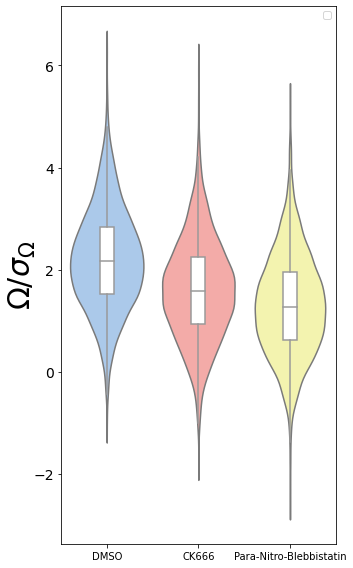

In [6]:
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

#calculate the normalized omegas
stds = []
for i,m in omegaframesep.groupby('Treatment'):
    stds.extend(m.bootstrap_omega/m.bootstrap_omega.std())
omegaframesep['Norm_Omegas'] = stds

fig, ax = plt.subplots(figsize=(5,8))#, sharex=True)
#plots
sns.violinplot(data=omegaframesep, x='Treatment', y='Norm_Omegas', 
               palette = colorlist, inner = None, ax=ax,) #order=['Random', 'Chem_Directed', 'Galv'])
sns.boxplot(data=omegaframesep, x='Treatment', y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax,) #order=['Random', 'Chem_Directed', 'Galv'])

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=30, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
# ax.set_xticklabels(['Random','Chemotaxis','Galvanotaxis'], fontsize = 14)



plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori} separated.png', bbox_inches='tight')


import scipy.stats as ss


f_val, p_val = ss.f_oneway(*[m.bootstrap_omega.to_list() for i,m in omegaframesep.groupby('Treatment')])
print(f'F value: {f_val}, p value: {p_val}')
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(omegaframesep.bootstrap_omega, omegaframesep.Treatment))



C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

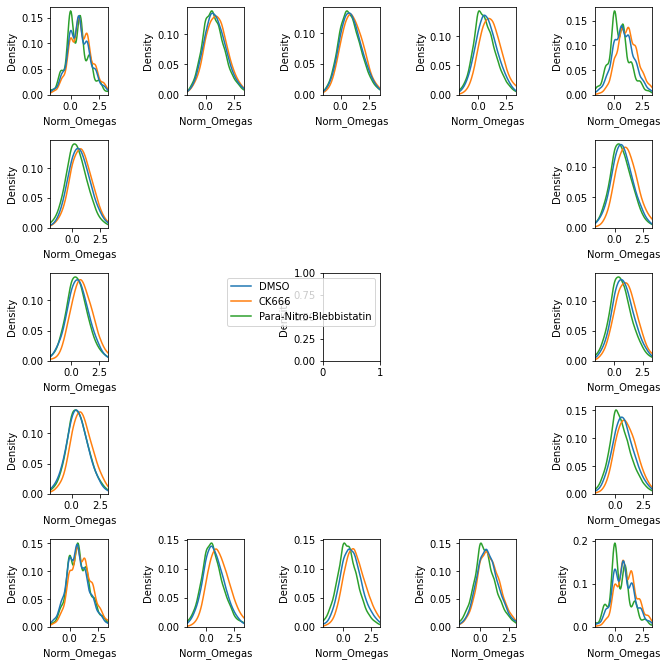

In [12]:
############ graph individual loop dot product distributions ##########
import seaborn as sns

fig, axes = plt.subplots(nbins, nbins, figsize = (20,20))
for x in range(nbins):
    for y in range(nbins):
        current = individualoms[(individualoms['x'] == x+1) & (individualoms['y'] == y+1)]
        if not current.empty:
            #calculate the normalized omegas
            stds = []
            for i,m in current.groupby('Treatment'):
                stds.extend(m.dotprod/m.dotprod.std())
            current['Norm_Omegas'] = stds
            
            sns.kdeplot(data = current.reset_index(), x = 'Norm_Omegas',hue = 'Treatment', common_norm=True, bw_adjust=1.5, ax = axes[nbins-y-1, x])
            stdzp = current.Norm_Omegas.mean()+(current.Norm_Omegas.std() * 2.5)
            stdzn = current.Norm_Omegas.mean()-(current.Norm_Omegas.std() * 2.51)
            axes[nbins-y-1, x].set_xlim([stdzn,stdzp])
            axes[nbins-y-1, x].get_legend().set_visible(False)
        elif (x==((nbins-1)/2)) and (y==((nbins-1)/2)):
            sns.kdeplot(x = [0,1,2],hue = individualoms.Treatment.unique().to_list(), ax = axes[nbins-y-1, x])
        else:
#             pass
#             print('empty')
            fig.delaxes(axes[nbins-y-1, x])
plt.tight_layout()
plt.savefig(savedir + f'individual dot products of uple{uple} and lori{lori} separated.png', bbox_inches='tight')

In [10]:
######### do NORMALIZED contour integrals for all migration modes ################
import itertools
from CustomFunctions.DetailedBalance import contour_integral
#upper left position of contour box
uple = [4,8]
#lower right position of contour box
lori = [8,4]

if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated_normalized.csv'):
    omegaframesep_norm = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated_normalized.csv', index_col=0)
else:
    omega_results = []
    for i, m in bsframe_sep_full.groupby('Treatment'):
        omegas = []
        iters = [[x]*(nbins**2) for x in range(int(len(m)/(nbins**2)))]#, len(migboot)
        m['bs_iteration'] = list(itertools.chain.from_iterable(iters))
        for l, b in m.groupby('bs_iteration'):
            omegas.append(contour_integral(b, uple, lori, norm = True))
        omega_results.append([i,omegas])
    omegaframesep_norm = pd.DataFrame([o[1] for o in omega_results], index = [o[0] for o in omega_results])
    dlist = []
    for m in omegaframesep_norm.T.columns.to_list():
        dlist.append(pd.DataFrame(list(zip(omegaframesep_norm.T[m].to_list(), [m]*len(omegaframesep_norm.T))), columns=['bootstrap_omega','Treatment']))
    omegaframesep_norm = pd.concat(dlist)
    omegaframesep_norm.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated_normalized.csv')

F value: 681.3612578917812, p value: 5.857351954571783e-284
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
group1          group2         meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
 CK666                    DMSO  -1.0896  -0.0 -1.2457 -0.9336   True
 CK666 Para-Nitro-Blebbistatin  -2.4526  -0.0 -2.6086 -2.2965   True
  DMSO Para-Nitro-Blebbistatin  -1.3629  -0.0  -1.519 -1.2069   True
--------------------------------------------------------------------


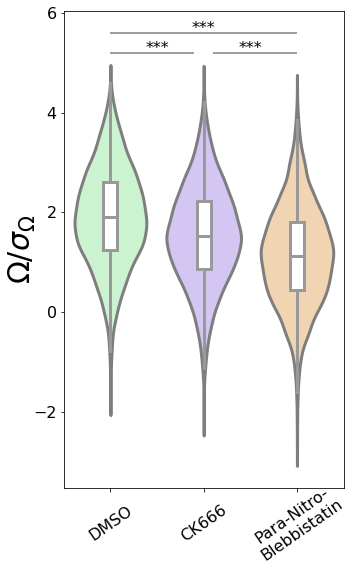

In [22]:
################ histograms of the NORMALIZED contour integral distributions ###########

colorlist = ['#c5fac9','#d0befa','#fcd6a7']

#calculate the normalized omegas
stds = []
for i,m in omegaframesep_norm.groupby('Treatment'):
    stds.extend(m.bootstrap_omega/m.bootstrap_omega.std())
omegaframesep_norm['Norm_Omegas'] = stds

fig, ax = plt.subplots(figsize=(5,8))#, sharex=True)
#plots
sns.violinplot(data=omegaframesep_norm, x='Treatment', y='Norm_Omegas', 
               palette = colorlist, linewidth = 3, inner = None, ax=ax,) #order=['Random', 'Chem_Directed', 'Galv'])
sns.boxplot(data=omegaframesep_norm, x='Treatment', y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, linewidth = 3, boxprops={'zorder': 2}, 
            ax=ax,) #order=['Random', 'Chem_Directed', 'Galv'])

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=30, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=16)
ax.set_xticklabels(labels = ['DMSO','CK666','Para-Nitro-\nBlebbistatin'], fontdict= {'fontsize': 16,
                                                                                      'verticalalignment':'center',
                                                                                      'rotation':35,
                                                                                      'y':-.06})#fontsize = 16, rotation = 35)

                                                    
# ax.tick_params('x', labelsize=16, rotation = 35)
plt.hlines(5.6, 0, 2, colors='grey', linestyles='solid')
ax.text(1,5.61,'***',fontdict= {'fontsize': 16,
                               'horizontalalignment':'center'})
plt.hlines(5.2, 0, .9, colors='grey', linestyles='solid')
ax.text(0.5,5.21,'***',fontdict= {'fontsize': 16,
                               'horizontalalignment':'center'})
plt.hlines(5.2, 1.1, 2, colors='grey', linestyles='solid')
ax.text(1.5,5.21,'***',fontdict= {'fontsize': 16,
                               'horizontalalignment':'center'})


plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori} separated normalized.png', bbox_inches='tight', dpi=500)


import scipy.stats as ss


f_val, p_val = ss.f_oneway(*[m.bootstrap_omega.to_list() for i,m in omegaframesep_norm.groupby('Treatment')])
print(f'F value: {f_val}, p value: {p_val}')
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(omegaframesep_norm.bootstrap_omega, omegaframesep_norm.Treatment))



In [108]:
currenttreat[[x for x in currenttreat.columns.to_list() if 'count' in x and 'rev' not in x]].to_numpy()[0], currentcontrol[[x for x in currentcontrol.columns.to_list() if 'count' in x and 'rev' not in x]].to_numpy()

(array([ 2,  8,  4, 13], dtype=int64), array([[ 4, 11,  9, 26]], dtype=int64))

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator


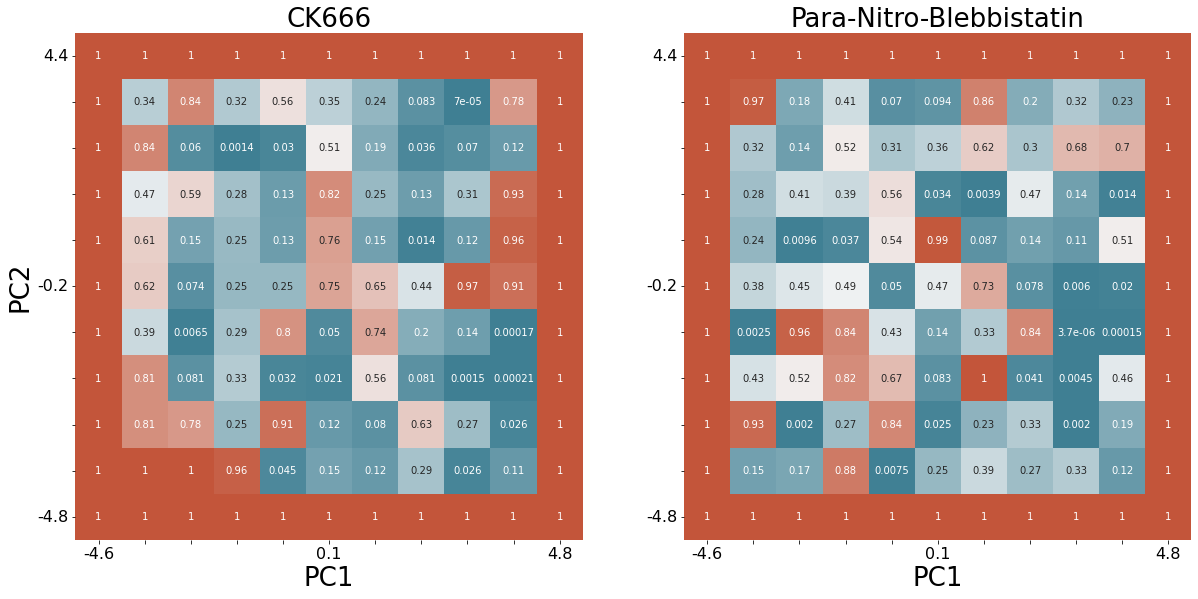

In [118]:
def cs(n, y):
    return scipy.stats.chisquare(n, np.sum(n)/np.sum(y) * y)
fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique())-1,figsize=(20,10))
iterr = 0
for i, t in enumerate(trans_rate_df_sep.Treatment.unique()):
    if t != "DMSO":
        ax = axes[iterr]
        iterr = iterr+1
        bighm = np.zeros((nbins,nbins))
        treat = trans_rate_df_sep[trans_rate_df_sep.Treatment == t]
        cont= trans_rate_df_sep[trans_rate_df_sep.Treatment == 'DMSO']
        for x in range(1,nbins+1):
            for y in range(1,nbins+1):
                currenttreat = treat[(treat['x'] == x) & (treat['y'] == y)]
                currentcontrol = cont[(cont['x'] == x) & (cont['y'] == y)]
                if (sum((currentcontrol[[x for x in currentcontrol.columns.to_list() if 'count' in x and 'rev' not in x]] ==0).all().to_list()) > 0) or (sum((currenttreat[[x for x in currenttreat.columns.to_list() if 'count' in x and 'rev' not in x]] ==0).all().to_list())>0):
                    pval = 1
                else:
                    chisq, pval = cs(currenttreat[[x for x in currenttreat.columns.to_list() if 'count' in x and 'rev' not in x]].to_numpy()[0],
                                     currentcontrol[[x for x in currentcontrol.columns.to_list() if 'count' in x and 'rev' not in x]].to_numpy()[0])
                bighm[y-1,x-1] = pval
                


        #plot heatmap with seaborn
        sns.heatmap(
            bighm,
            vmin=0, vmax=1, #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            annot=True,
            cbar=i==0,
            cbar_ax = None if i else cbar_ax,
    #         cbar_kws=cbar_kws
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for i, l in enumerate(ax.xaxis.get_ticklabels()):
            if i%5 != 0:
                l.set_visible(False)
        for i, l in enumerate(ax.yaxis.get_ticklabels()):
            if i%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)

        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(t, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 26)
    
plt.savefig(savedir + 'PC1_PC2 chi squared maps separated.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator


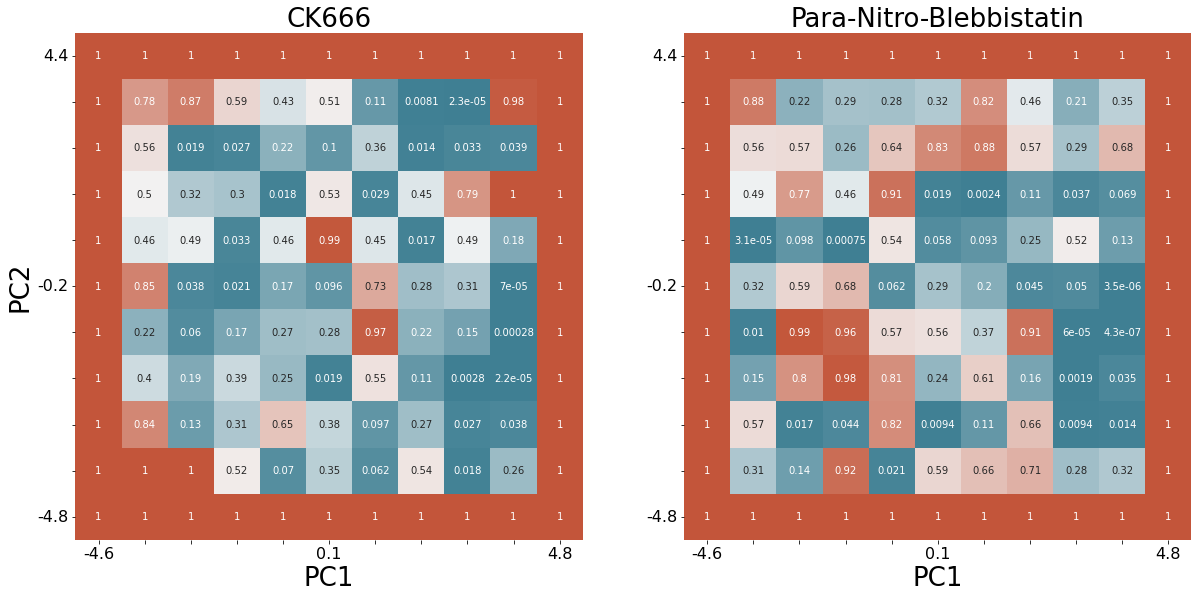

In [119]:
################## chi square heatmaps with forward and reverse rates ##########
def cs(n, y):
    return scipy.stats.chisquare(n, np.sum(n)/np.sum(y) * y)
fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique())-1,figsize=(20,10))
iterr = 0
for i, t in enumerate(trans_rate_df_sep.Treatment.unique()):
    if t != "DMSO":
        ax = axes[iterr]
        iterr = iterr+1
        bighm = np.zeros((nbins,nbins))
        treat = trans_rate_df_sep[trans_rate_df_sep.Treatment == t]
        cont= trans_rate_df_sep[trans_rate_df_sep.Treatment == 'DMSO']
        for x in range(1,nbins+1):
            for y in range(1,nbins+1):
                currenttreat = treat[(treat['x'] == x) & (treat['y'] == y)]
                currentcontrol = cont[(cont['x'] == x) & (cont['y'] == y)]
                if (sum((currentcontrol[[x for x in currentcontrol.columns.to_list() if 'count' in x]] ==0).all().to_list()) > 0) or (sum((currenttreat[[x for x in currenttreat.columns.to_list() if 'count' in x and 'rev' not in x]] ==0).all().to_list())>0):
                    pval = 1
                else:
                    chisq, pval = cs(currenttreat[[x for x in currenttreat.columns.to_list() if 'count' in x]].to_numpy()[0],
                                     currentcontrol[[x for x in currentcontrol.columns.to_list() if 'count' in x]].to_numpy()[0])
                bighm[y-1,x-1] = pval
                


        #plot heatmap with seaborn
        sns.heatmap(
            bighm,
            vmin=0, vmax=1, #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            annot=True,
            cbar=i==0,
            cbar_ax = None if i else cbar_ax,
    #         cbar_kws=cbar_kws
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for i, l in enumerate(ax.xaxis.get_ticklabels()):
            if i%5 != 0:
                l.set_visible(False)
        for i, l in enumerate(ax.yaxis.get_ticklabels()):
            if i%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)

        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(t, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC2', fontsize = 26)
    
plt.savefig(savedir + 'PC1_PC2 chi squared FR maps separated.png', bbox_inches='tight')

In [47]:
############### get shcoeffs for different positions around a particular 2d contour #############
from CustomFunctions.PCanimation import interpolate_contour_shapes
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x]].mean().to_numpy()

pca = pk.load(open(savedir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10

fourcorners = np.array([[4,7],
[4,3],
[9,3],
[9,7]])

contour_positions, loopname = interpolate_contour_shapes(fourcorners,
                               avgpcs,
                               whichpcs,
                               pca,
                               PC1bins,
                               PC2bins,
                               savedir,
                               lmax)

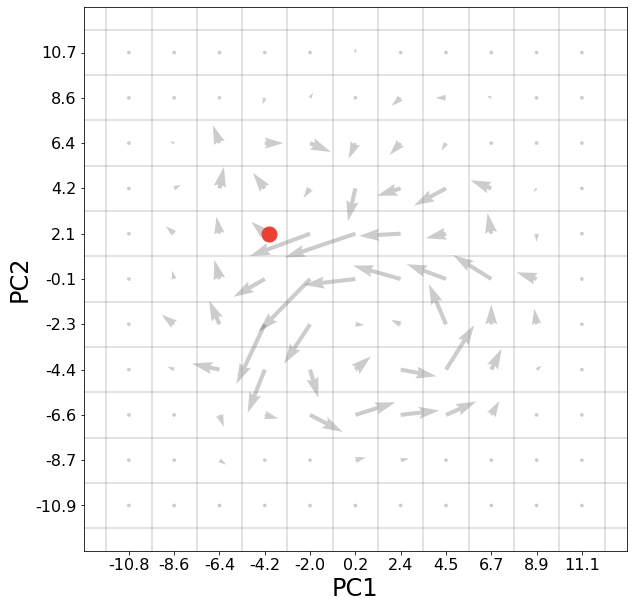

In [48]:
########## animate a contour loop graph
from matplotlib.animation import FuncAnimation 

scale = 0.0005

#make fig
fig, ax = plt.subplots(figsize = (10,10))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

    

for x in range(nbins):
    for y in range(nbins):
        current = trans_rate_df[(trans_rate_df['x'] == x+1) & (trans_rate_df['y'] == y+1)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#             print(anglecolor)
        ax.quiver((x+1),
                   (y+1), 
                   xcurrent, 
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'black',
                 alpha = 0.2)    
    
    

ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(contour_positions[0,1],contour_positions[0,2], marker="o", color = '#eb4034', markersize = 15)

# make function for updating point position
def animate(i, contour_positions):
    point.set_data([contour_positions[i,1]], [contour_positions[i,2]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(contour_positions))), fargs = (contour_positions,))
# plt.show()

ani.save(savedir + 'contours/' + loopname + f'/{loopname}_plotanimation_PC1-PC2.mp4', fps=30, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


In [173]:
############## get the actual bin position reconstructions for still images ##########

from CustomFunctions.PCanimation import animate_PCs

avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x]].mean().to_numpy()

pca = pk.load(open(savedir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10



fourcorners = np.array([[4,7],
[4,3],
[9,3],
[9,7]])



for x in fourcorners:
    #translate pc bins into actual pcs
    PCs = [(PC1bins[x[0]-1]+PC1bins[x[0]])/2, (PC2bins[x[1]-1]+PC2bins[x[1]])/2]

    specificdir = savedir + str(x) + '.vtp'
    animate_PCs(avgpcs, #average value for all PCs generated with the pca
            whichpcs, #which PC number is being reconstructed
            PCs, #list of PCs, [0] is the first PC, [1] is the second
            pca, #actual pca file
            specificdir,
            lmax,)